# imports

In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import mlflow
import itertools
from loss_functions import forecast_loss
from model import MeanModel

## Loading data

In [6]:
n = 1000
torch.manual_seed(0)
stocks = torch.randint(0, 10, (n,))
demand = torch.poisson(torch.ones(n) * 2.0)
sales = torch.min(demand, stocks)

In [7]:
# helper functions

def get_optimizer(model:MeanModel, lr: float, weight_decay:float, optimizer_name:str="SGD" ):
   """
   The get_optimizer function returns an optimizer object.
   
   :param lr: float: Set the learning rate
   :param weight_decay:float: Add l2 regularization to the loss function
   :param optimizer_name:str: Specify the optimizer to use
   :return: An optimizer object
   """
   
   if optimizer_name == "SGD":
      return torch.optim.SGD(model.parameters(), lr=lr,weight_decay=weight_decay)
   elif optimizer_name=="adam":
      return torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
   else:
      raise ValueError(f"Unsupported optimizer: {optimizer_name}")
   
def plot_loss(learning_rates, weight_decays, num_epochs, all_val_losses):
    """
    The plot_loss function takes in the learning rates, weight decays, number of epochs and all validation losses.
    It then plots a graph with the x-axis being the number of epochs and y-axis being the validation loss value.
    The label for each line is LR=learning rate, WD=weight decay.
    
    :param learning_rates: Set the learning rate for each of the models
    :param weight_decays: Specify the weight decay values to be used
    :param num_epochs: Set the number of epochs for which we want to train our model
    :param all_val_losses: Plot the validation loss for different hyperparameter values
    :return: A plot of the validation loss for each combination of hyperparameters
    """
    plt.figure(figsize=(12, 6))
    for i, (lr, weight_decay) in enumerate(itertools.product(learning_rates, weight_decays)):
        plt.plot(range(1, num_epochs + 1), all_val_losses[i], label=f'LR={lr}, WD={weight_decay}')

    plt.title('Validation Loss for Different Hyperparameter Values')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss Value')
    plt.legend()
    plt.grid(True)
    plt.show()
    
def plot_mae(learning_rates, weight_decays, num_epochs, all_val_maes):
    """
    The plot_mae function plots the mean absolute error (MAEs) for each of the hyperparameter combinations.
    
    :param learning_rates: Define the learning rates that will be used in the training
    :param weight_decays: Set the weight decay values
    :param num_epochs: Set the number of epochs to train for
    :param all_val_maes: Store the maes for each epoch
    :return: A plot of the mean absolute error (maes) for different hyperparameter values
    """
    plt.figure(figsize=(12, 6))
    for i, (lr, weight_decay) in enumerate(itertools.product(learning_rates, weight_decays)):
        plt.plot(range(1, num_epochs + 1), all_val_maes[i], label=f'LR={lr}, WD={weight_decay}', linestyle='--')

    plt.title('Mean Absolute Error (MAE) for Different Hyperparameter Values')
    plt.xlabel('Epoch')
    plt.ylabel('MAE Value')
    plt.legend()
    plt.grid(True)
    plt.show()


def get_or_create_experiment(experiment_name):

    existing_experiment = mlflow.get_experiment_by_name(experiment_name)

    if existing_experiment:
        print(f"Experiment '{experiment_name}' already exists.")
        return existing_experiment.experiment_id
    else:
        # Create a new experiment
        experiment_id = mlflow.create_experiment(experiment_name)
        print(f"Experiment '{experiment_name}' created.")
        return experiment_id


## comparing MSE and Poisson loss functions:

In [13]:
lr = 0.01
num_epochs = 100
optimizer_name = "SGD"
weight_decay = 1e-05
poisson_losses, mse_losses = [],[]

model = MeanModel()

optimizer = get_optimizer(model,lr,weight_decay,optimizer_name)


losses = []
for loss_function in ["poisson", "mse"]:
    print(loss_function)
    for epoch in range(num_epochs):
   
        optimizer.zero_grad()
        outputs = model(n)
        loss = forecast_loss(outputs, demand, stocks,loss_function)
            
        loss.backward()
        optimizer.step()
        if loss_function=="poisson":
            poisson_losses.append(loss.item())
        else:
            mse_losses.append(loss.item())
            
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


poisson
Epoch [10/100], Loss: 1.5657750368118286
Epoch [20/100], Loss: 1.3793823719024658
Epoch [30/100], Loss: 1.2181750535964966
Epoch [40/100], Loss: 1.0814776420593262
Epoch [50/100], Loss: 0.9679253697395325
Epoch [60/100], Loss: 0.8755612969398499
Epoch [70/100], Loss: 0.8019954562187195
Epoch [80/100], Loss: 0.7445968985557556
Epoch [90/100], Loss: 0.7006898522377014
Epoch [100/100], Loss: 0.6677229404449463
mse
Epoch [10/100], Loss: 3.9897210597991943
Epoch [20/100], Loss: 3.380951404571533
Epoch [30/100], Loss: 2.974532127380371
Epoch [40/100], Loss: 2.7032034397125244
Epoch [50/100], Loss: 2.522062063217163
Epoch [60/100], Loss: 2.4011306762695312
Epoch [70/100], Loss: 2.3203952312469482
Epoch [80/100], Loss: 2.266496181488037
Epoch [90/100], Loss: 2.2305119037628174
Epoch [100/100], Loss: 2.206488847732544


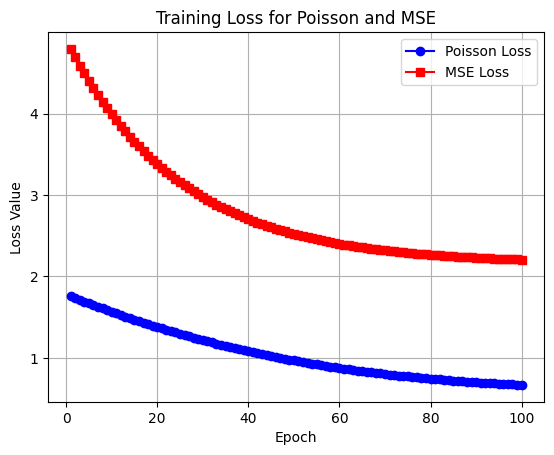

In [14]:
plt.plot(range(1, num_epochs + 1), poisson_losses, label='Poisson Loss', color='blue', marker='o')

plt.plot(range(1, num_epochs + 1), mse_losses, label='MSE Loss', color='red', marker='s')

plt.title('Training Loss for Poisson and MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)
plt.show()

## hyperparameter tuning
### optimizer: SGD, loss function: poisson loss

In [12]:
import itertools

loss_function = "poisson"
optimizer_name = "SGD"
learning_rates = [0.05, 0.1, 0.01]
weight_decays = [0.005, 0.0001,0.001]

num_epochs = 50
batch_size = 32

best_loss = float('inf')
best_hyperparameters = {}
epochs = range(1, num_epochs + 1)
all_val_maes,all_val_losses =[],[]

# setting up mlflow stuff
experiment_name = "hyperparams grid search"
experiment_id = get_or_create_experiment(experiment_name)

mlflow.set_experiment(experiment_name)


# Perform grid search
for lr, weight_decay in itertools.product(learning_rates, weight_decays):
    print(f"training mean model using LR: {lr},wd: {weight_decay}")
    with mlflow.start_run():

        model = MeanModel()
        optimizer = get_optimizer(model,lr,weight_decay,optimizer_name)

        train_size = int(0.8 * n)
        train_stocks, train_demand, train_sales = stocks[:train_size], demand[:train_size], sales[:train_size]
        val_stocks, val_demand, val_sales = stocks[train_size:], demand[train_size:], sales[train_size:]
        val_losses = []
        mae_epoch = [] 


        for epoch in range(num_epochs):
            
            # Training loop
            for i in range(0, train_size, batch_size):
                batch_stocks = train_stocks[i:i + batch_size]
                batch_demand = train_demand[i:i + batch_size]
                batch_sales = train_sales[i:i + batch_size]

                optimizer.zero_grad()
                outputs = model(len(batch_sales))
                loss = forecast_loss(outputs, batch_demand, batch_stocks, loss_function)
                loss.backward()
                optimizer.step()

            # Validation loop
            model.eval()
            val_outputs = model(len(val_sales))
            val_loss = forecast_loss(val_outputs, val_demand, val_stocks, loss_function)
            val_losses.append(val_loss.item())
        
            # Calculate MAE during validation
            mae = torch.mean(torch.abs(val_outputs - val_demand))
            mae_epoch.append(mae.item())
            
            if (epoch + 1) % 10 == 0:
                print(f"Epoch: [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss.item()}, MAE: {mae.item()}")
            
            # Log metrics during each epoch
            mlflow.log_metric("MAE validation",  mae.item(), step=epoch)
            mlflow.log_metric("poisson_loss validation ", val_loss.item(), step=epoch)

            #get hyper params for best loss
            if val_loss < best_loss:
                best_loss = val_loss
                best_hyperparameters = {'lr': lr, 'weight_decay': weight_decay}

        # log best params    
        mlflow.log_params({"best_lr": best_hyperparameters['lr'], "best_weight_decay": best_hyperparameters['weight_decay']})
        mlflow.log_params({"lr": lr, "weight_decay": weight_decay})
        mlflow.log_metric("best validation loss",best_loss)
        mlflow.pytorch.log_model(model, "models")

        all_val_losses.append(val_losses)
        all_val_maes.append(mae_epoch)

print("Best Hyperparameters:", best_hyperparameters)
mlflow.end_run()


Experiment 'hyperparams grid search' already exists.
training mean model using LR: 0.05,wd: 0.005
Epoch: [10/50], Validation Loss: 0.8061027526855469, MAE: 1.4332246780395508
Epoch: [20/50], Validation Loss: 0.8061027526855469, MAE: 1.4332246780395508
Epoch: [30/50], Validation Loss: 0.8061027526855469, MAE: 1.4332246780395508
Epoch: [40/50], Validation Loss: 0.8061027526855469, MAE: 1.4332246780395508
Epoch: [50/50], Validation Loss: 0.8061027526855469, MAE: 1.4332246780395508
training mean model using LR: 0.05,wd: 0.0001
Epoch: [10/50], Validation Loss: 0.8060606122016907, MAE: 1.4325037002563477
Epoch: [20/50], Validation Loss: 0.8060606122016907, MAE: 1.4325037002563477
Epoch: [30/50], Validation Loss: 0.8060606122016907, MAE: 1.4325037002563477
Epoch: [40/50], Validation Loss: 0.8060606122016907, MAE: 1.4325037002563477
Epoch: [50/50], Validation Loss: 0.8060606122016907, MAE: 1.4325037002563477
training mean model using LR: 0.05,wd: 0.001
Epoch: [10/50], Validation Loss: 0.806068

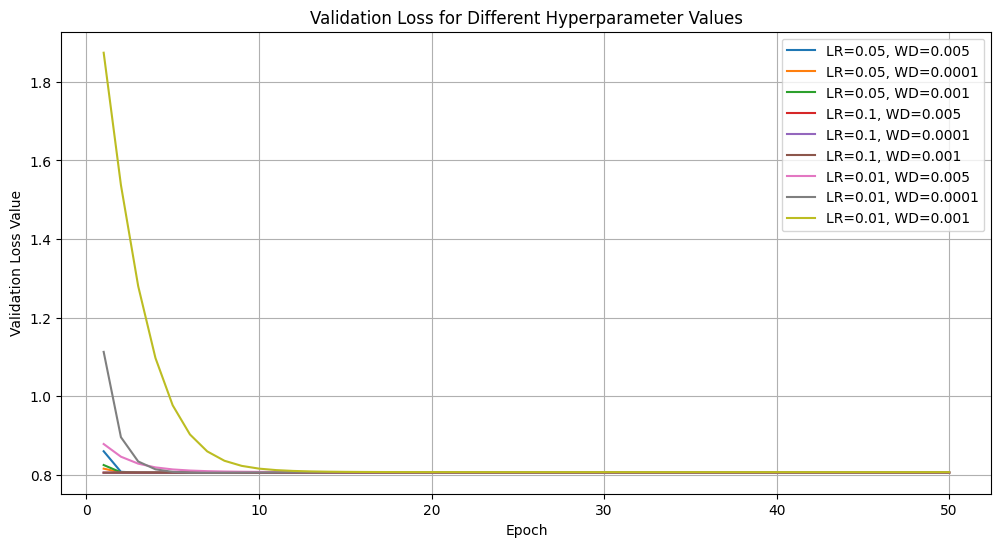

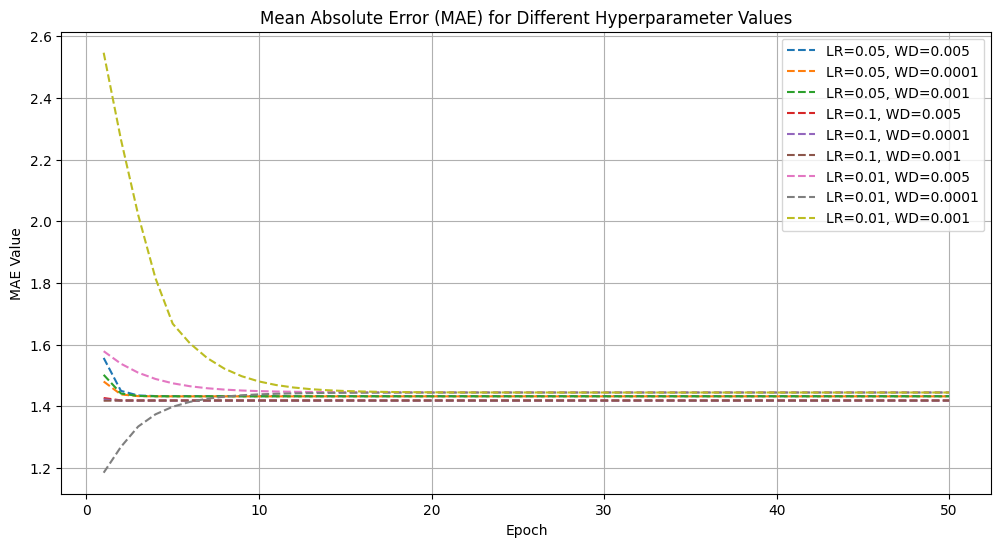

In [9]:
# plot 
plot_loss(learning_rates, weight_decays, num_epochs, all_val_losses)
plot_mae(learning_rates, weight_decays, num_epochs, all_val_maes)